# Imports

In [1]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-07-28 14:42:40,010 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.4
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [3]:
_work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [4]:
%matplotlib inline


import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


### Query DB for contact IDs

In [5]:
export_fn = 'contract_trainset_meta.temp.csv'

try:
    stats = pd.read_csv(export_fn, index_col=0)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'])
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'])
    # stats = pd.to_datetime(stats['analyze_date'])
    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except:
    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
print(lastdate)
stats

2021-07-23 12:29:19.231000


,checksum,version,export_date,analyze_date,subject,value,value_log1p,value_span,org-1-alias,org-2-alias,org-1-name,org-2-name,subject confidence,user_correction_date,valid
5e21826bf9721f1cbeaa01d9,e0f7b7cbbbac371621c7e8cb88c1fb2e,2.3.14,2021-07-27 17:38:29.153960,2020-01-17 09:48:01.839,RealEstate,6.000000e+07,17.909855,336.0,Продавец,Покупатель,Газпромнефть-Терминал,Недвижимость,0.659141,NaT,NaN
5e21826bf9721f1cbeaa01dc,3151d91e3234a9cf448b1c3d2f00577e,2.3.14,2021-07-27 17:38:29.751678,2020-01-17 09:50:01.359,Deal,5.400000e+07,17.804495,293.0,Заказчик,Исполнитель,Газпромнефть-Терминал,Петров Петр Петрович,0.761068,NaT,NaN
5e21826bf9721f1cbeaa01dd,a3bd7285f7fa43a3e43ba02f48b94f2c,2.3.14,2021-07-27 17:38:30.297508,2020-01-17 09:51:10.921,RealEstate,5.900000e+07,17.893048,1376.0,Продавец,Покупатель,Газпромнефть-Терминал,Ромашка,0.251680,NaT,NaN
5e257bb473698e191112be7b,7d811ff935432b80274dceac4e557100,2.3.14,2021-07-27 17:38:30.485369,2020-06-16 08:35:11.009,Charity,4.900000e+05,13.102163,114.0,Жертвователь,Благополучатель,Газпромнефть-Региональные продажи,Детский дом,0.745545,2020-01-20 12:17:49.138,NaN
5e257bb473698e191112be7c,152867cabbb47e63fe4631dc980c99c7,2.3.14,2021-07-27 17:38:30.851224,2020-06-16 08:42:52.920,Charity,NaN,NaN,NaN,Благотворитель,Благополучатель,Газпромнефть-Региональные продажи,Благо,0.741096,2020-06-16 08:41:51.310,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60ec5576cddbb3c487368c45,9afd3f4c0c6385de2e8fcc34cae08127,2.4.4,2021-07-27 18:08:11.491446,2021-07-12 17:45:35.242,Service,NaN,NaN,NaN,Исполнитель,NaN,БДО Юникон,Газпром-нефть,0.998591,NaT,NaN
60ed762acddbb3c487368c4d,a27ac3740ad890dfe2f5694ebb0b9c96,2.4.4,2021-07-27 18:08:12.537849,2021-07-13 14:17:22.202,Service,1.874714e+10,23.654307,1751.0,Заказчик,Исполнитель,Газпром нефть,Научно-исследовательский и проектный институт ...,1.000000,2021-07-13 12:02:37.446,NaN
60f01196cddbb3c487368c5b,80e83cd9a074bfe817932dd4a1eb3364,2.4.4,2021-07-27 18:08:13.897420,2021-07-15 13:48:02.451,Service,3.971388e+09,22.102381,398.0,Заказчик,Исполнитель,Газпром нефть,Архитектурно-проектная мастерская «Стелс» - 2010,1.000000,2021-07-15 11:33:08.843,NaN
60f5c5b6d624fbd2b4175db8,00fab1e7e1671a2e1cffe35b0fc0ad60,2.4.4,2021-07-27 18:08:14.762456,2021-07-19 21:34:49.800,Service,1.874714e+10,23.654307,1749.0,Заказчик,Исполнитель,Газпром нефть,Научно-исследовательский и проектный институт ...,1.000000,2021-07-19 18:42:25.352,NaN


In [6]:
query = {
  '$and': [
    {"parse.documentType": "CONTRACT"},
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
res = documents_collection.find(filter=query,
                                projection={'_id': True, 'user.updateDate':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(200)

res = list([i for i in res])

_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего новых документов после 2021-07-23 12:29:19.231000 : 4

[{'_id': ObjectId('60b7a547061c76d775454f3c'),
  'user': {'updateDate': datetime.datetime(2021, 7, 28, 11, 36, 43, 452000)}},
 {'_id': ObjectId('5fbbe466a2b4551c06107adc'),
  'user': {'updateDate': datetime.datetime(2021, 7, 28, 11, 11, 8, 983000)}},
 {'_id': ObjectId('5fe48217b770574a005555a4'),
  'user': {'updateDate': datetime.datetime(2021, 7, 28, 11, 6, 25, 700000)}},
 {'_id': ObjectId('5fca2aab9083b679224c75e3'),
  'user': {'updateDate': datetime.datetime(2021, 7, 27, 15, 9, 19, 178000)}}]

In [7]:
from datetime import datetime
from math import log1p

from pandas import DataFrame

from analyser.persistence import DbJsonDoc
from trainsets.retrain_contract_uber_model import flatten_attributes_tree


def add_stats_record(d: DbJsonDoc, stats: DataFrame):
  _id = str(d.get_id())

  attr_map = flatten_attributes_tree(d.get_attributes_tree())

  # stats.at[_id, 'valid'] = True

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  if 'version' in d.analysis['attributes_tree']:
    stats.at[_id, 'version'] = '.'.join([str(x) for x in d.analysis['attributes_tree']['version']])
  else:
    stats.at[_id, 'version'] = d.analysis['version']

  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'analyze_date'] = d.analysis['analyze_timestamp']

  subj_att = attr_map['subject']  # find_in_dict('subject', d.get_attributes_tree())
  if subj_att:
    stats.at[_id, 'subject'] = subj_att['value']
  else:
    stats.at[_id, 'valid'] = False

  _value_tag = attr_map['sign_value_currency/value']
  if _value_tag:
    stats.at[_id, 'value'] = _value_tag['value']
    stats.at[_id, 'value_log1p'] = log1p(_value_tag['value'])
    stats.at[_id, 'value_span'] = _value_tag['span'][0]
    # find_in_dict('price.amount.span.0', d.get_attributes_tree())

  if attr_map['sign_value_currency/currency']:
    stats.at[_id, 'currency'] = attr_map['sign_value_currency/currency']['value']

  if attr_map['org-1-alias']:
    stats.at[_id, 'org-1-alias'] = attr_map['org-1-alias']['value']

  if attr_map['org-2-alias']:
    stats.at[_id, 'org-2-alias'] = attr_map['org-2-alias']['value']

  if attr_map['org-1-name']:
    stats.at[_id, 'org-1-name'] = attr_map['org-1-name']['value']

  if attr_map['org-2-name']:
    stats.at[_id, 'org-2-name'] = attr_map['org-2-name']['value']

  if subj_att:
    stats.at[_id, 'subject confidence'] = subj_att['confidence']

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = d.user[
      'updateDate']  # find_in_dict('attributes_tree.creation_date', d.user)


In [8]:
# res[:4]

docs_ids = [i["_id"] for i in res]   
# stats = DataFrame()
    

for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    
    add_stats_record(jd, stats)
    
    if k % 100 == 0:
        print(k)
        stats.to_csv(export_fn, index=True)
    
stats.to_csv(export_fn, index=True)
stats

0


,checksum,version,export_date,analyze_date,subject,value,value_log1p,value_span,org-1-alias,org-2-alias,org-1-name,org-2-name,subject confidence,user_correction_date,valid,currency
5e21826bf9721f1cbeaa01d9,e0f7b7cbbbac371621c7e8cb88c1fb2e,2.3.14,2021-07-27 17:38:29.153960,2020-01-17 09:48:01.839,RealEstate,6.000000e+07,17.909855,336.0,Продавец,Покупатель,Газпромнефть-Терминал,Недвижимость,0.659141,NaT,NaN,NaN
5e21826bf9721f1cbeaa01dc,3151d91e3234a9cf448b1c3d2f00577e,2.3.14,2021-07-27 17:38:29.751678,2020-01-17 09:50:01.359,Deal,5.400000e+07,17.804495,293.0,Заказчик,Исполнитель,Газпромнефть-Терминал,Петров Петр Петрович,0.761068,NaT,NaN,NaN
5e21826bf9721f1cbeaa01dd,a3bd7285f7fa43a3e43ba02f48b94f2c,2.3.14,2021-07-27 17:38:30.297508,2020-01-17 09:51:10.921,RealEstate,5.900000e+07,17.893048,1376.0,Продавец,Покупатель,Газпромнефть-Терминал,Ромашка,0.251680,NaT,NaN,NaN
5e257bb473698e191112be7b,7d811ff935432b80274dceac4e557100,2.3.14,2021-07-27 17:38:30.485369,2020-06-16 08:35:11.009,Charity,4.900000e+05,13.102163,114.0,Жертвователь,Благополучатель,Газпромнефть-Региональные продажи,Детский дом,0.745545,2020-01-20 12:17:49.138,NaN,NaN
5e257bb473698e191112be7c,152867cabbb47e63fe4631dc980c99c7,2.3.14,2021-07-27 17:38:30.851224,2020-06-16 08:42:52.920,Charity,NaN,NaN,NaN,Благотворитель,Благополучатель,Газпромнефть-Региональные продажи,Благо,0.741096,2020-06-16 08:41:51.310,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60ec5576cddbb3c487368c45,9afd3f4c0c6385de2e8fcc34cae08127,2.4.4,2021-07-27 18:08:11.491446,2021-07-12 17:45:35.242,Service,NaN,NaN,NaN,Исполнитель,NaN,БДО Юникон,Газпром-нефть,0.998591,NaT,NaN,NaN
60ed762acddbb3c487368c4d,a27ac3740ad890dfe2f5694ebb0b9c96,2.4.4,2021-07-27 18:08:12.537849,2021-07-13 14:17:22.202,Service,1.874714e+10,23.654307,1751.0,Заказчик,Исполнитель,Газпром нефть,Научно-исследовательский и проектный институт ...,1.000000,2021-07-13 12:02:37.446,NaN,NaN
60f01196cddbb3c487368c5b,80e83cd9a074bfe817932dd4a1eb3364,2.4.4,2021-07-27 18:08:13.897420,2021-07-15 13:48:02.451,Service,3.971388e+09,22.102381,398.0,Заказчик,Исполнитель,Газпром нефть,Архитектурно-проектная мастерская «Стелс» - 2010,1.000000,2021-07-15 11:33:08.843,NaN,NaN
60f5c5b6d624fbd2b4175db8,00fab1e7e1671a2e1cffe35b0fc0ad60,2.4.4,2021-07-27 18:08:14.762456,2021-07-19 21:34:49.800,Service,1.874714e+10,23.654307,1749.0,Заказчик,Исполнитель,Газпром нефть,Научно-исследовательский и проектный институт ...,1.000000,2021-07-19 18:42:25.352,NaN,NaN


In [9]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
# stats2

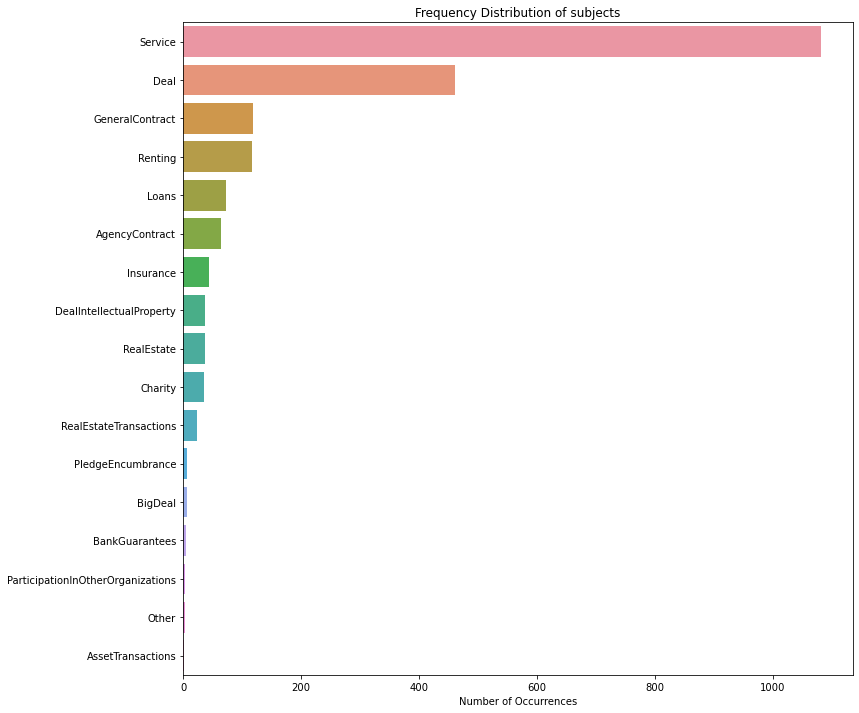

In [10]:
%matplotlib inline

cnt = stats2['subject'].value_counts()
# alias_count = stats2['org-1-alias'].value_counts()

#plot distribution---------------------
plt.figure(figsize=(12, 12))
sns.barplot(x=cnt.values, y=cnt.index)

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()

In [11]:
stats2['org-1-alias'].value_counts()

заказчик                   537
исполнитель                429
покупатель                 283
продавец                    82
поставщик                   67
                          ... 
управляемая организация      1
владелец свх                 1
предприятие                  1
мтс                          1
агентство                    1
Name: org-1-alias, Length: 63, dtype: int64

In [12]:
stats2['org-2-alias'].value_counts()

заказчик                       464
исполнитель                    442
поставщик                      242
покупатель                     155
подрядчик                       97
арендодатель                    64
арендатор                       50
продавец                        39
займодавец                      37
благополучатель                 29
страховщик                      27
принципал                       26
лицензиат                       24
заемщик                         22
оператор                        22
лицензиар                       14
агент                           13
клиент                          10
сублицензиат                    10
пользователь                     9
общество                         9
спонсор                          7
страхователь                     6
абонент                          6
сторона-2                        6
правообладатель                  6
банк                             6
сторона 2                        5
поручитель          

In [13]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            a_weight = row['value']
            if a_weight>0:
                stats2.at[i, score_column_name] *= log1p(a_weight)
        
            
def calc_column_val_importance(stats2, column_name):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            a_weight = counts[val]
            stats2.at[i, score_column_name] *= 1./log1p(a_weight)
        else:
            stats2.at[i, score_column_name] *= 1.0

for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'
    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 2.)

calc_column_val_importance(stats2, 'org-1-name')
calc_column_val_importance(stats2, 'org-2-name')
calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')

# calc_user_importance(stats2)
calc_val_importance(stats2)

stats2 = stats2.drop_duplicates(subset=['checksum']).sort_values([score_column_name], ascending=False)
# 



sub = stats2[['url','version', 'org-1-name', 'org-2-name', 'org-1-alias', 'org-2-alias', 'subject', 'value', 'user_correction_date']]
sub.to_csv('contract_trainset_meta.hp.csv', index=True)
sub

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,NaT
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,NaT
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT
...,...,...,...,...,...,...,...,...,...
5fe4821bb770574a0055565d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.14,издательско-полиграфическое предприятие «масте...,захаров александр станиславович,заказчик,исполнитель,Service,NaN,2020-12-25 08:23:17.164
5fe48217b770574a0055559c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.14,издательско-полиграфическое предприятие «масте...,захаров александр станиславович,заказчик,исполнитель,Service,NaN,2020-12-25 08:25:20.306
5fe48217b770574a005555a4,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.14,издательско-полиграфическое предприятие «масте...,захаров александр станиславович,заказчик,исполнитель,Service,NaN,2021-07-28 11:06:25.700
60b7a4c2061c76d7754545c4,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,газпромнефть-снабжение,заказчик,исполнитель,Service,NaN,2021-06-22 09:17:31.134
